In [1]:
import numpy as np
import scipy.io as spio
import os
import cv2
import matplotlib.pyplot as plt
import glob

import numpy as np
from PIL import Image

In [2]:
pwd = os.getcwd() # current path

#### Load original images from clothing-co-parsing

In [3]:
image_path = pwd + '/photos/'
label_path = pwd + '/annotations/pixel-level/'

In [4]:
valid_exts = [".jpg", ".mat"] # file extensions

In [5]:
image_list = [i for i in sorted(os.listdir(image_path)) if os.path.splitext(i)[1].lower() in valid_exts]
label_list = [i for i in sorted(os.listdir(label_path)) if os.path.splitext(i)[1].lower() in valid_exts]

In [6]:
print(image_list[0], len(image_list), len(label_list))

0001.jpg 2098 1004


#### Check label data

In [7]:
label_data_ex = spio.loadmat(label_path +'/0001.mat')

In [8]:
print(label_data_ex)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 19 15:20:27 2014', '__globals__': [], 'groundtruth': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), '__version__': '1.0'}


dtype is uint and key of dict is 'groundtruth'

### Images of clothing-co-parsing data vary in size

In [9]:
label_data_ex = np.array(label_data_ex['groundtruth'], dtype = np.uint32)

In [10]:
label_data_ex.shape

(832, 550)

In [11]:
img = cv2.imread(image_path + image_list[0], 0)
img.shape

(832, 550)

In [12]:
img = cv2.imread(image_path + image_list[0], 1)

### cv2 save the image as BGR type so change to RGB

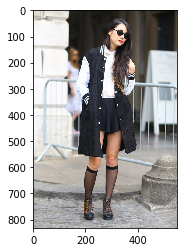

In [13]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [14]:
mask_ex = spio.loadmat(label_path + label_list[0])

In [15]:
mask_ex['groundtruth'].shape

(832, 550)

In [16]:
mask_ex['groundtruth']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

### Image.fromarray() chage data array to image without value change

In [17]:
img = Image.fromarray(mask_ex['groundtruth'])
img.save('test.png')

In [18]:
label_img = cv2.imread('test.png',  cv2.IMREAD_GRAYSCALE)

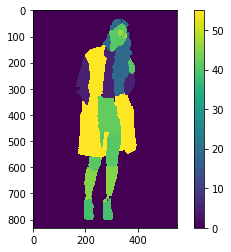

In [19]:
plt.imshow(label_img)
plt.colorbar()

### Label data have class from 0 to 58

In [20]:
np.unique(label_img)

array([ 0,  5, 19, 39, 41, 42, 45, 47, 55], dtype=uint8)

In [21]:
label_img.shape

(832, 550)

### mat file save as png file(not jpg)

In [22]:
save_dir = "./label_images/" # path where you want to save

if not os.path.exists(save_dir): # if there is no exist, make the path
    os.makedirs(save_dir)

In [23]:
def mat_to_img(label_names):
    for i, img_name in enumerate(label_names):
        mask_ex = spio.loadmat(label_path + label_list[i])
        img = Image.fromarray(mask_ex['groundtruth'])
        img.save(save_dir+ str(i+1) + '.png')# png right number

In [24]:
mat_to_img(label_list)

## set resize

In [25]:
IMG_H, IMG_W = 384, 256

In [26]:
x_train = np.zeros((len(image_list), IMG_H, IMG_W, 3), dtype=np.uint8)
y_train = np.zeros((len(label_list), IMG_H, IMG_W, 1), dtype=np.uint8)

### image resize

In [27]:
save_dir = "./images/" # path where you want to save

if not os.path.exists(save_dir): # if there is no exist, make the path
    os.makedirs(save_dir)

In [28]:
for i, image in enumerate(image_list):
    img = cv2.imread(image_path + image, 1)
    img = cv2.resize(img, dsize=(IMG_W, IMG_H))
    cv2.imwrite(save_dir + str(i+1) + '.png', img)
    x_train[i] = img

In [29]:
x_train.shape

(2098, 384, 256, 3)

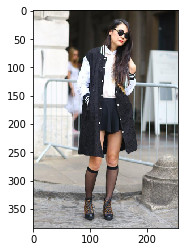

In [30]:
plt.imshow(cv2.cvtColor(x_train[0,:], cv2.COLOR_BGR2RGB))

### label resize

In [31]:
save_dir = './label_images/resize/'
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)

In [32]:
for i, image in enumerate(label_list):
    img = cv2.imread('./label_images/' + str(i+1) + '.png' , cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, dsize=(IMG_W, IMG_H), interpolation= cv2.INTER_NEAREST)
    cv2.imwrite(save_dir + str(i+1) + '.png', img)
    y_train[i] = np.expand_dims(img, axis = 2)

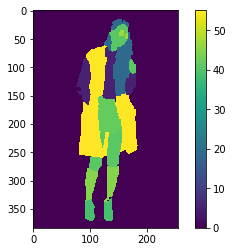

In [33]:
plt.imshow(y_train[0].reshape([IMG_H, IMG_W]))
plt.colorbar()

In [34]:
np.unique(y_train[0])

array([ 0,  5, 19, 39, 41, 42, 45, 47, 55], dtype=uint8)

In [35]:
y_train.shape

(1004, 384, 256, 1)

In [36]:
x_train.shape

(2098, 384, 256, 3)

In [37]:
save_dir = "./dataset/" # path where you want to save

if not os.path.exists(save_dir): # if there is no exist, make the path
    os.makedirs(save_dir)
    
np.save(save_dir+'x_train.npy', x_train[:900])
np.save(save_dir+'y_train.npy', y_train[:900])
np.save(save_dir+'x_test.npy', x_train[900:1000])
np.save(save_dir+'y_test.npy', y_train[900:1000])

## This code performs image segmentation by converting it into four classes

In [38]:
x_train = np.load('dataset/x_train.npy').astype(np.float32)
x_test = np.load('dataset/x_test.npy').astype(np.float32)
y_train = np.load('dataset/y_train.npy').astype(np.float32)
y_test = np.load('dataset/y_test.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(900, 384, 256, 3) (900, 384, 256, 1)
(100, 384, 256, 3) (100, 384, 256, 1)


### 0 - null, 41 - skin, 19 - hair, anothers - clothes

### chagne 0 - null, 1 - skin, 2 - hair, 3 - clothes

In [39]:
def change_class(x):
    num_of_data = x.shape[0]
    x = x.reshape([num_of_data,-1])
    result = np.zeros(x.shape)
    classes = [0, 41, 19]
    
    for k in range(num_of_data):
        for i, v in enumerate(x[k]):
            if v not in classes:
                result[k][i] = 3 # clothes
            else:
                if v == 0:
                    result[k][i] = 0 # background
                elif v == 41:
                    result[k][i] = 1 # skin
                else:
                    result[k][i] = 2 # hair
              
    return result

In [40]:
y_label_train = change_class(y_train)

In [41]:
y_label_train.shape

(900, 98304)

In [42]:
y_label_train = y_label_train.reshape([-1, IMG_H, IMG_W,1])
print(y_label_train.shape)

(900, 384, 256, 1)


In [43]:
np.unique(y_label_train)

array([0., 1., 2., 3.])

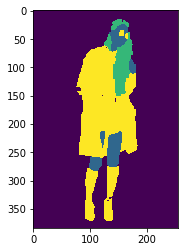

In [44]:
plt.imshow(np.squeeze(y_label_train[0]))

In [45]:
y_label_test = change_class(y_test)

In [46]:
y_label_test = y_label_test.reshape([-1, IMG_H, IMG_W,1])
y_label_test.shape

(100, 384, 256, 1)

### One hot encoding using keras lib

In [47]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [48]:
y_label_train_onehot = to_categorical(y_label_train, num_classes = 4)

In [49]:
y_label_train_onehot.shape

(900, 384, 256, 4)

In [50]:
y_label_test_onehot = to_categorical( y_label_test, num_classes = 4)
y_label_test_onehot.shape

(100, 384, 256, 4)

In [51]:
save_dir = "./dataset/" # path where you want to save
np.save(save_dir+'y_train_onehot.npy', y_label_train_onehot)
np.save(save_dir+'y_test_onehot.npy', y_label_test_onehot)